In [1]:
import re
import sketch
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import geojson
import folium
from folium.plugins import HeatMap
from summarytools import dfSummary

In [2]:
sin = pd.read_csv("siniestros.csv")
sin.head(3)

,id,fecha,año,mes,día,hora,hh,dirección,tipo de calle,comuna,...,participantes,acusado,rol acusado,n_victimas,victima,sexo,edad,fecha fallecimiento,día semana,barrios
0,2016-0001,2016-01-01,2016,1,1,04:00:00,4,"PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",AVENIDA,8,...,MOTO-AUTO,AUTO,CONDUCTOR,1,MOTO,MASCULINO,19,2016-01-01,viernes,villa lugano - villa riachuelo - villa soldati
1,2016-0004,2016-01-10,2016,1,10,00:00:00,0,"LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",AVENIDA,8,...,MOTO-SD,SD,CONDUCTOR,1,MOTO,MASCULINO,18,NaN,domingo,villa lugano - villa riachuelo - villa soldati
2,2016-0008,2016-01-24,2016,1,24,18:30:00,18,27 DE FEBRERO AV. y ESCALADA AV.,AVENIDA,8,...,MOTO-OBJETO FIJO,OBJETO FIJO,CONDUCTOR,1,MOTO,MASCULINO,30,2016-01-24,domingo,villa lugano - villa riachuelo - villa soldati


In [3]:
sin.describe()

,año,mes,día,comuna,n_victimas
count,715.000000,715.000000,715.000000,715.000000,715.000000
mean,2018.180420,6.675524,15.935664,7.451748,1.061538
std,1.671028,3.570954,8.676818,4.373508,0.257363
min,2016.000000,1.000000,1.000000,1.000000,1.000000
25%,2017.000000,4.000000,9.000000,4.000000,1.000000
50%,2018.000000,7.000000,16.000000,8.000000,1.000000
75%,2019.000000,10.000000,23.000000,11.000000,1.000000
max,2021.000000,12.000000,31.000000,15.000000,3.000000


In [4]:
sin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   715 non-null    object
 1   fecha                715 non-null    object
 2   año                  715 non-null    int64 
 3   mes                  715 non-null    int64 
 4   día                  715 non-null    int64 
 5   hora                 715 non-null    object
 6   hh                   715 non-null    object
 7   dirección            707 non-null    object
 8   tipo de calle        715 non-null    object
 9   comuna               715 non-null    int64 
 10  xy (caba)            715 non-null    object
 11  pos x                715 non-null    object
 12  pos y                715 non-null    object
 13  participantes        715 non-null    object
 14  acusado              715 non-null    object
 15  rol acusado          715 non-null    object
 16  n_victim

In [5]:
sin.rename(columns={'rol acusado': 'rol victima'}, inplace=True)

## Correlación de variables

Analizamos únicamente las columnas que contienen números.

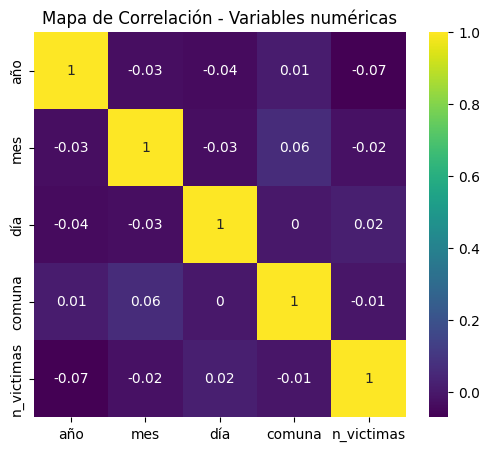

In [6]:
dataNumerica = sin.select_dtypes(include=['number']) 
corr = dataNumerica.corr().round(2)

plt.figure(figsize=(6,5))
sns.heatmap(corr, cmap="viridis", annot=True)
plt.title('Mapa de Correlación - Variables numéricas')
plt.show()

Podemos encontrar una correlación positiva y pequeña entre la edad y la hora de ocurrencia. El resto de las correlatividades es negativa o despreciable.

Analicemos el comportamiento de la variable de número de víctimas que está relacionado al objetivo final del proyecto que tiene que ver con reducir el número de víctimas fatales.

## Víctimas

/var/folders/vk/hsfysc513dd4j0c513j6pl3r0000gn/T/ipykernel_59214/3625834195.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df_filtrado, x='n_victimas', palette="Paired")


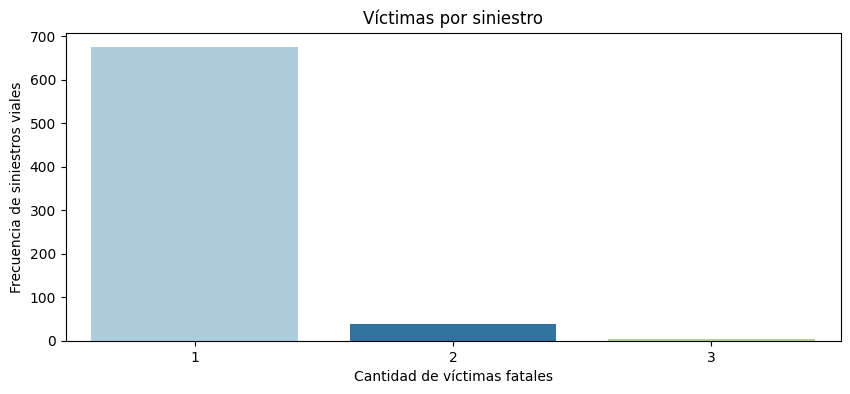

In [7]:
plt.figure(figsize=(10, 4))

df_filtrado = sin[sin["n_victimas"] != 0]

sns.countplot(df_filtrado, x='n_victimas', palette="Paired")

plt.ylabel("Frecuencia de siniestros viales")
plt.xlabel("Cantidad de víctimas fatales")
plt.title("Víctimas por siniestro")

plt.show()

La gran mayoría de los casos concentra un total de 1 víctima fatal.

# Edades

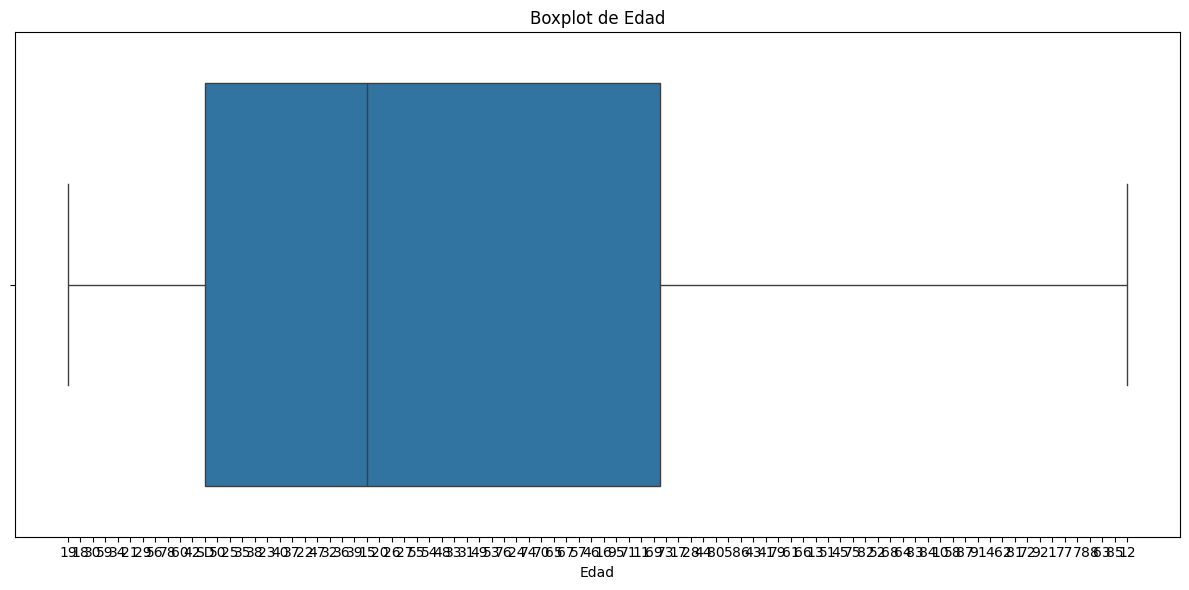

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(x=sin['edad'], ax=ax)
ax.set_title('Boxplot de Edad') ; ax.set_xlabel('Edad')

plt.tight_layout()
plt.show()

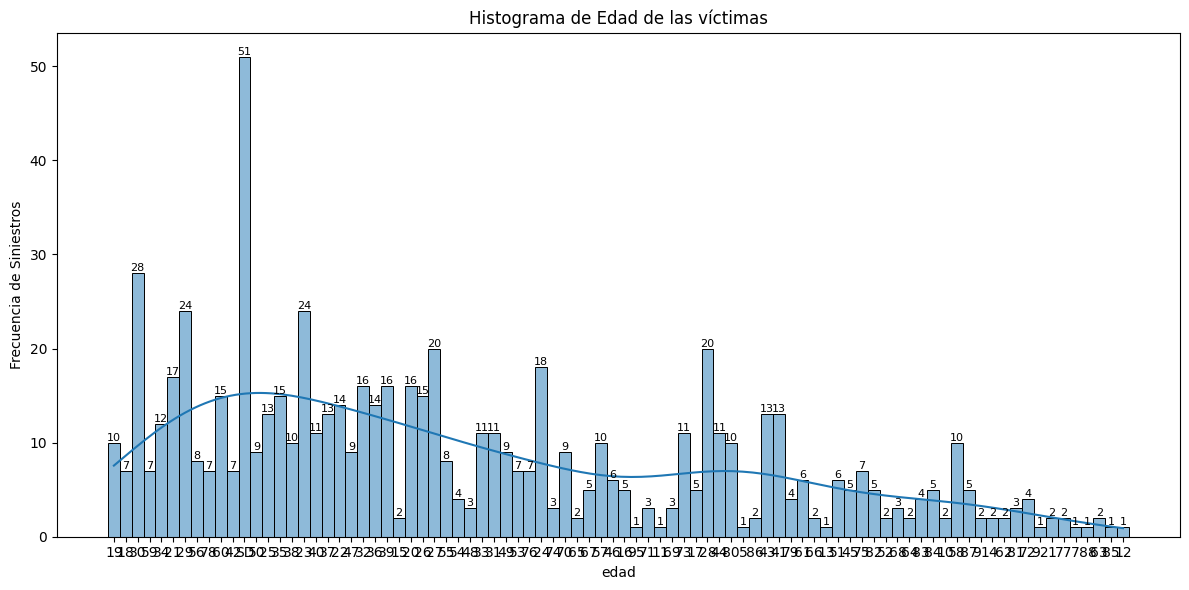

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(sin['edad'], kde=True, ax=ax)
ax.set_title('Histograma de Edad de las víctimas') ; ax.set_ylabel('Frecuencia de Siniestros')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=8, color='black')

plt.tight_layout()
plt.show()

In [10]:
sin["edad"].describe()

count     715
unique     86
top        SD
freq       51
Name: edad, dtype: object

La mayor cantidad de las víctimas se concentraron entre los 20 y 40 años, y en menor medida hasta los 60 años. Mientras que la media es de 42 años, el 75% tiene menos de 56 años.

### Relación Edad - Hora - Sexo

In [11]:
data = sin.groupby(['edad', "hh", "sexo"])['n_victimas'].sum().reset_index()
data["edad"]=data["edad"].astype("Int64")
data["hh"]=data["hh"].astype("Int64")

plt.figure(figsize=(12, 6))
sns.scatterplot(data=sin, x='edad', y='hh', hue='sexo', alpha=0.5, palette='winter', s=100)

plt.xlabel('Edad de las Víctimas')
plt.ylabel('Hora del Siniestro')
plt.title('Relación entre Edad de las Víctimas, Hora del Siniestro y Sexo')

plt.legend(title='Sexo')
plt.show()


ValueError: invalid literal for int() with base 10: 'SD'

Tenemos una concentración marcada de víctimas masculinas entre 20 y 40 años que fueron víctimas fatales de siniestros viales ocurridos entre las 3 y 10 de la mañana.

A su vez, podemos encontrar un grupo de víctimas femeninas de alrededor de 80 años de edad entre las 10 y 15hs.

### Edades según Año

/var/folders/vk/hsfysc513dd4j0c513j6pl3r0000gn/T/ipykernel_3915/1224237411.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='año', y='edad', data=sin, palette="spring")


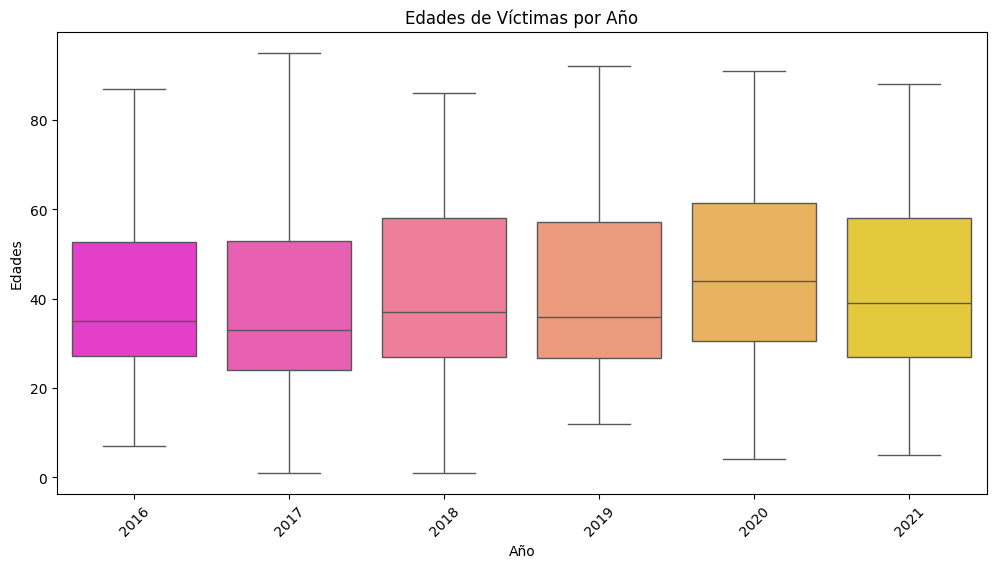

In [ ]:
data = sin.groupby(['edad', "año"])['n_victimas'].sum().reset_index()


plt.figure(figsize=(12, 6))
sns.boxplot(x='año', y='edad', data=sin, palette="spring")

plt.title('Edades de Víctimas por Año') ; plt.xlabel('Año') ; plt.ylabel('Edades')
plt.xticks(rotation=45)
plt.show()


La media por edad para cada año no supera los 40 años para todos los años menos en el 2020 que se encuentra justo por arriba.

# Proporción según sexo

Text(0.5, 1.0, 'Proporción según sexo')

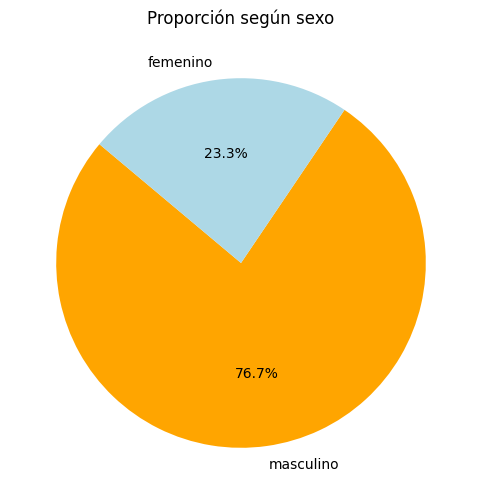

In [ ]:
proporcion = sin['sexo'].value_counts(normalize=True) * 100

labels = proporcion.index
sizes = proporcion.values

plt.figure(figsize=(12, 6))

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['orange', 'lightblue'])
plt.title("Proporción según sexo")

### Edad según sexo

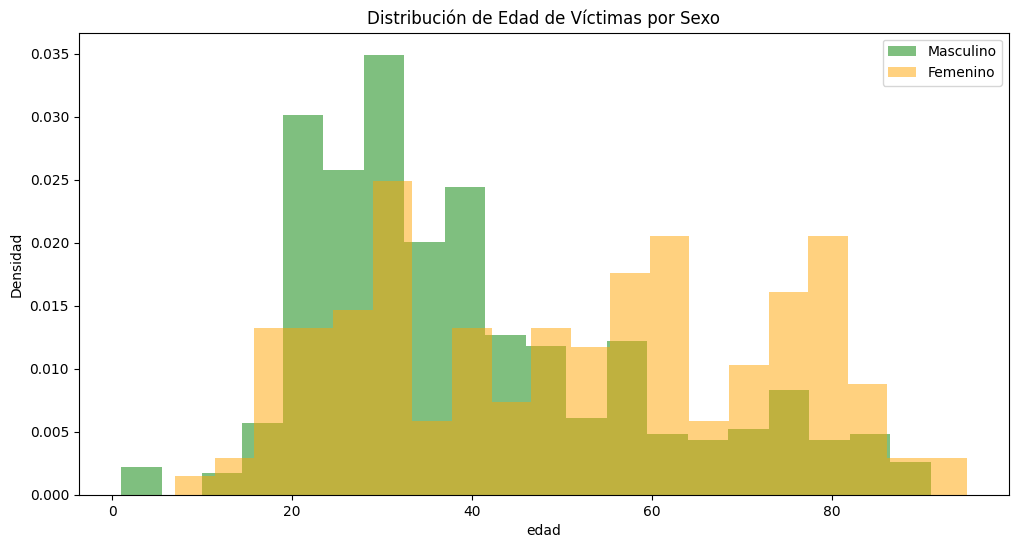

In [ ]:
masculino = sin[sin['sexo'] == 'masculino']['edad'].dropna()

femenino = sin[sin['sexo'] == 'femenino']['edad'].dropna()

plt.figure(figsize=(12, 6))
plt.hist(masculino, bins=20, alpha=0.5, color='green', label='Masculino', density=True)
plt.hist(femenino, bins=20, alpha=0.5, color='orange', label='Femenino', density=True)
plt.title('Distribución de Edad de Víctimas por Sexo')
plt.xlabel('edad')
plt.ylabel('Densidad')
plt.legend()
plt.show()

Hay mayor probabilidad de encontrar una víctima del sexo masculino que tenga entre 20 a 50 años de edad.

En caso de ser femenino se concentra en grupos de menos de 20 hasta pasados los 30, de 45 a 65 años y cercanos a 80 años.

### Rol acusado según sexo

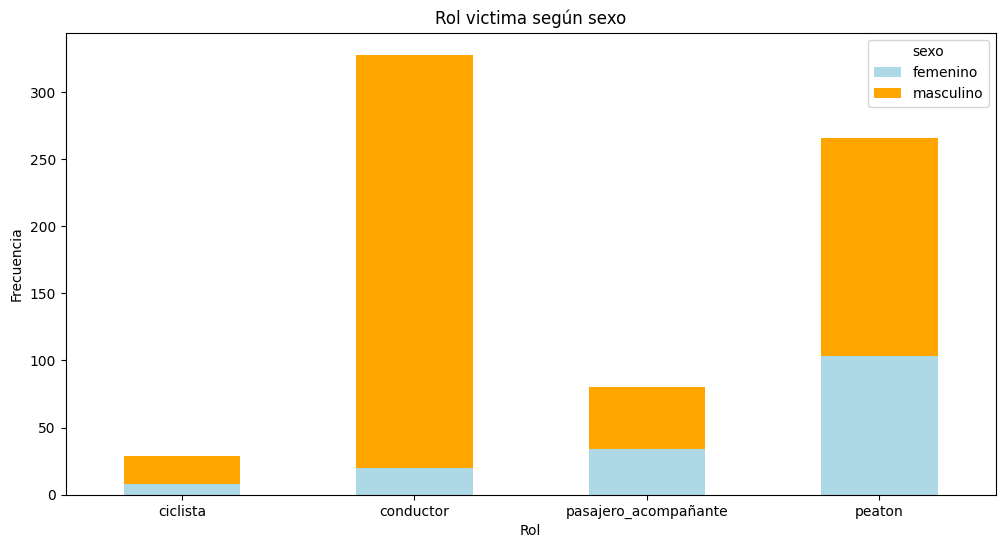

In [ ]:
tabla_contingencia = pd.crosstab(sin['rol victima'], sin['sexo'])

ax = tabla_contingencia.plot(kind='bar', stacked=True, figsize=(12, 6), color=["lightblue",'orange'])
plt.title('Rol victima según sexo')
plt.xlabel('Rol')
plt.ylabel('Frecuencia')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=['femenino', 'masculino'], title='sexo')

plt.xticks(rotation=0)
plt.show()

El rol de la víctima más común suele ser el de conductor, seguido de peatón, en el primero en su gran mayoría siendo masculino y en el segundo casi de igual medida para ambos sexos.

### Medio de la víctima - Sexo

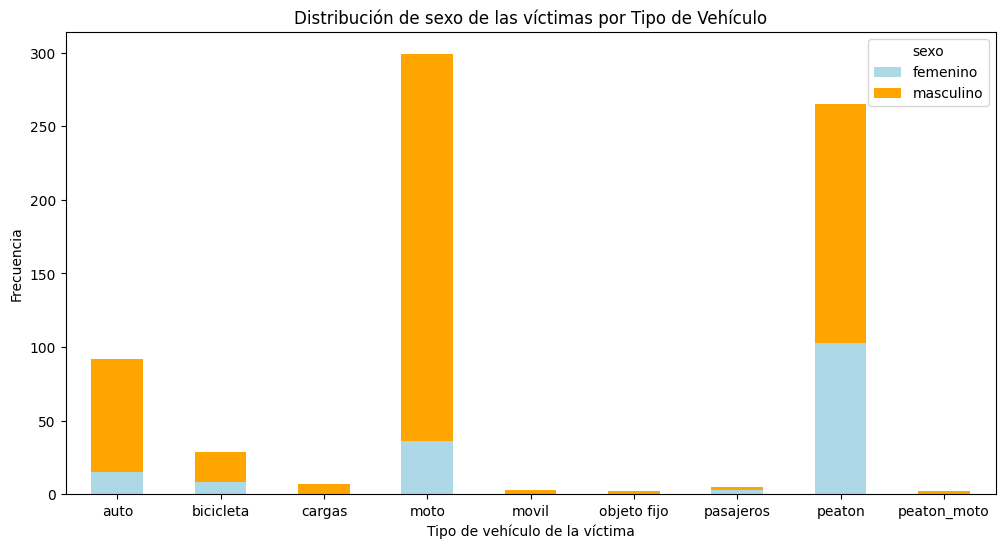

In [ ]:
tabla_contingencia = pd.crosstab(sin['victima'], sin['sexo'])

ax = tabla_contingencia.plot(kind='bar', stacked=True, figsize=(12, 6), color=["lightblue",'orange'])
plt.title('Distribución de sexo de las víctimas por Tipo de Vehículo')
plt.xlabel('Tipo de vehículo de la víctima')
plt.ylabel('Frecuencia')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=['femenino', 'masculino'], title='sexo')

plt.xticks(rotation=0)
plt.show()

La gran mayoría de víctimas fatales se concentra en masculinos en moto, seguido por peatones de ambos sexos.

## Distribución en el tiempo

### A través de los años

In [ ]:
temporal = sin.groupby(['año', 'mes'])['n_victimas'].sum().reset_index()
temporal["año"]= temporal["año"].astype("Int64")
temporal["mes"]= temporal["mes"].astype("Int64")
temporal["fecha"] = temporal["año"].astype(str) + '-' + temporal["mes"].astype(str)
temporal["fecha"] = pd.to_datetime(temporal["fecha"])
temporal = temporal.sort_values("fecha")
temporal

,año,mes,n_victimas,fecha
0,2016,1,8,2016-01-01
1,2016,2,12,2016-02-01
2,2016,3,15,2016-03-01
3,2016,4,11,2016-04-01
4,2016,5,7,2016-05-01
...,...,...,...,...
67,2021,8,9,2021-08-01
68,2021,9,4,2021-09-01
69,2021,10,5,2021-10-01
70,2021,11,8,2021-11-01


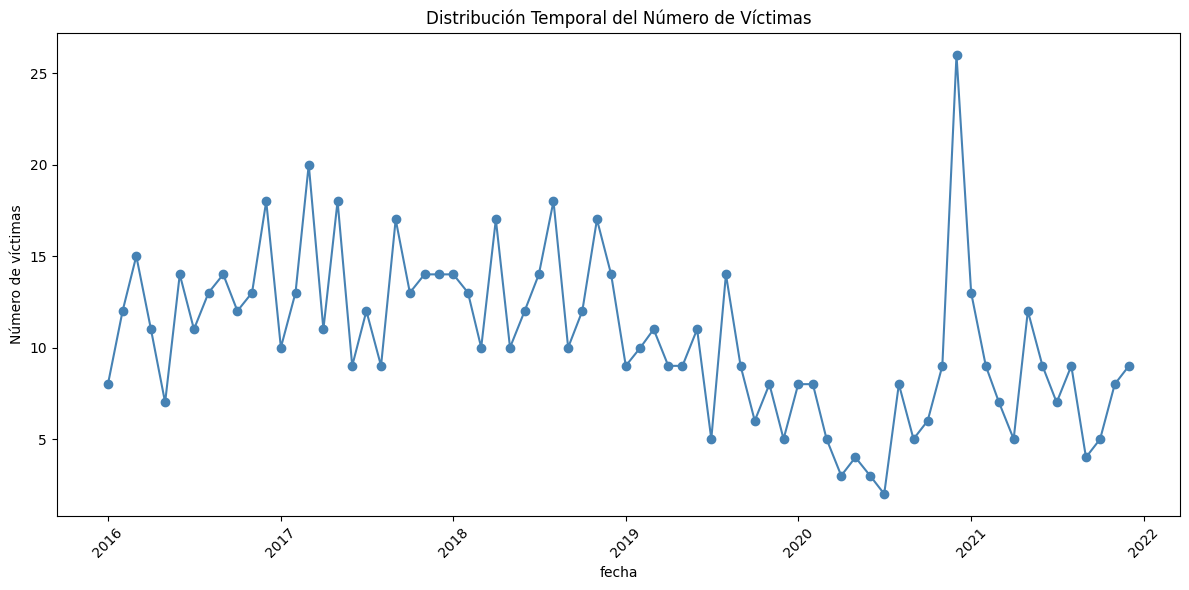

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(temporal["fecha"], temporal["n_victimas"], marker='o', color='steelblue')

plt.title('Distribución Temporal del Número de Víctimas')
plt.xlabel('fecha')
plt.ylabel('Número de víctimas')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Las fechas con mayor cantidad de siniestros se concentra en un rango entre el año 2017 y 2018. También podemos identificar una disminución sostenida hasta mediados del año 2020 influenciado seguramente por la cuarentena obligatoria.
A finales del 2020 podemos ver un pico con poco más de 25 víctimas fatales.

### Según mes

/var/folders/vk/hsfysc513dd4j0c513j6pl3r0000gn/T/ipykernel_3915/3416013282.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='mes', y='n_victimas', data=data, palette="spring")


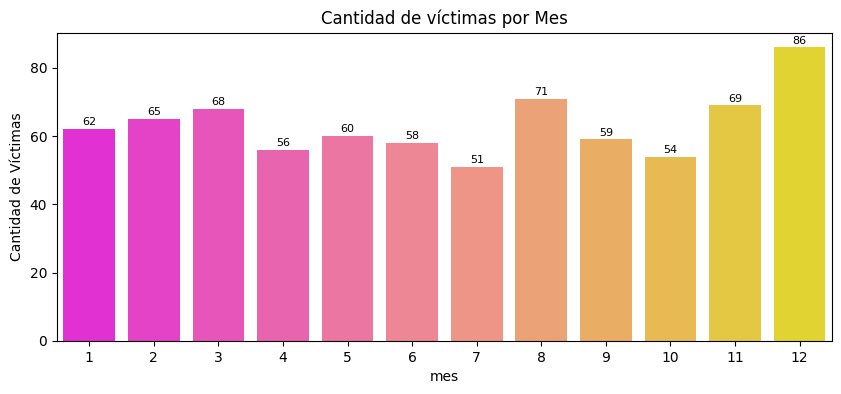

In [ ]:
data = sin.groupby(['mes'])['n_victimas'].sum().reset_index()
data["mes"]=data["mes"].astype("Int64")

plt.figure(figsize=(10,4))

ax = sns.barplot(x='mes', y='n_victimas', data=data, palette="spring")
ax.set_title('Cantidad de víctimas por Mes')
ax.set_xlabel('mes') ; ax.set_ylabel('Cantidad de Víctimas')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

Diciembre y subsiguientemente Agosto son los meses con mayor conteo de víctimas.

### Según día de la semana

/var/folders/vk/hsfysc513dd4j0c513j6pl3r0000gn/T/ipykernel_3915/3176176571.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='día semana', y='n_victimas', data=data, palette="spring")


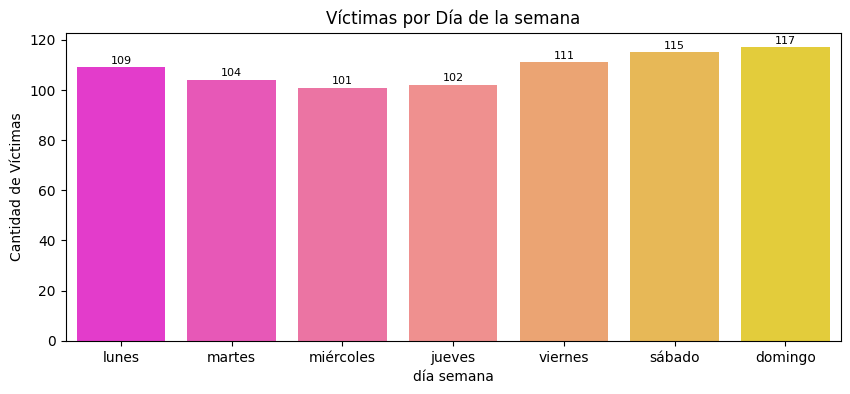

In [ ]:
data = sin.groupby(['día semana'])['n_victimas'].sum().reset_index()

orden_dias_semana = ["lunes", "martes", "miércoles", "jueves", "viernes", "sábado", "domingo"]

data['Orden_dia_semana'] = data['día semana'].apply(lambda x: orden_dias_semana.index(x))

data = data.sort_values(by='Orden_dia_semana')



plt.figure(figsize=(10,4))

ax = sns.barplot(x='día semana', y='n_victimas', data=data, palette="spring")
ax.set_title('Víctimas por Día de la semana')
ax.set_xlabel('día semana') ; ax.set_ylabel('Cantidad de Víctimas')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

En este orden, días Domingo, Sábado y Viernes son los que concentran mayor número de víctimas. Seguramente esté relacionado a las salidas del fin de semana, y el Domingo particularmente al ser la vuelta de las del Sábado por la noche, entre otros motivos.

/var/folders/vk/hsfysc513dd4j0c513j6pl3r0000gn/T/ipykernel_3915/913346624.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='día', y='n_victimas', data=data, palette="spring")


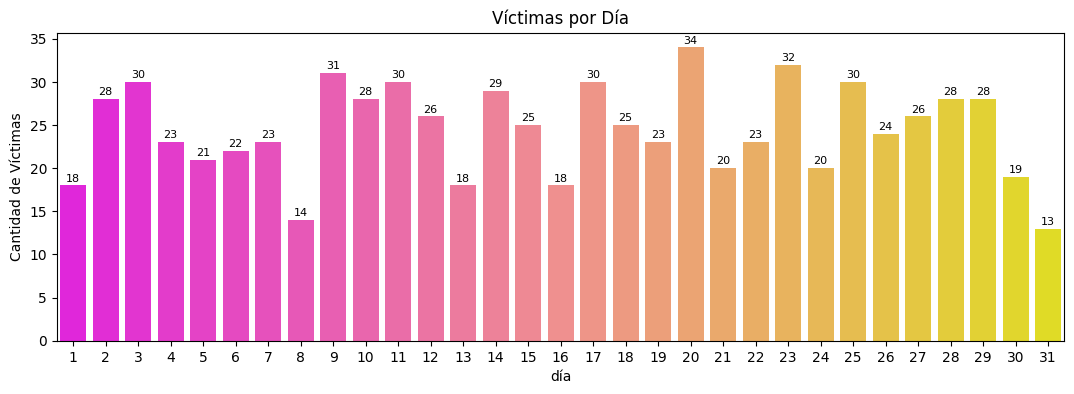

In [ ]:
data = sin.groupby(['día'])['n_victimas'].sum().reset_index()
data["día"]=data["día"].astype("Int64")

plt.figure(figsize=(13,4))

ax = sns.barplot(x='día', y='n_victimas', data=data, palette="spring")
ax.set_title('Víctimas por Día')
ax.set_xlabel('día') ; ax.set_ylabel('Cantidad de Víctimas')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

Podemos ver una mayor concentración de víctimas los 20 de cada mes. Los puntos más bajos son el 31 y el 8 de cada mes. No parecería tener un comportamiento cíclico semanal. También se podría ver afectado por los años no bisiestos.

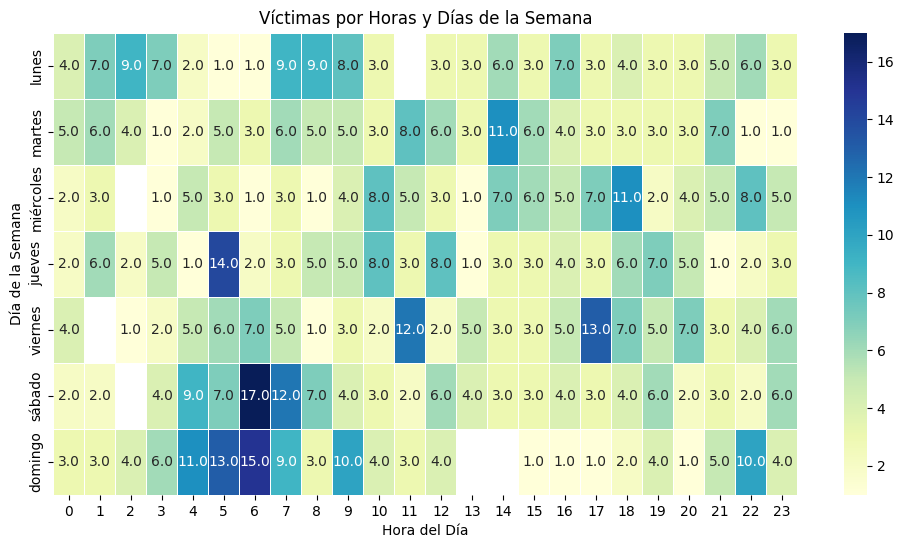

In [ ]:
data = sin.groupby(['día semana', "hh"])['n_victimas'].sum().reset_index()
data["hh"]=data["hh"].astype("Int64")

orden_dias_semana = ["lunes", "martes", "miércoles", "jueves", "viernes", "sábado", "domingo"]

data['Orden_dia_semana'] = data['día semana'].apply(lambda x: orden_dias_semana.index(x))

data = data.sort_values(by='Orden_dia_semana')

pivot_data = data.pivot_table(index= 'día semana', columns='hh', values='n_victimas', aggfunc='sum')
pivot_data = pivot_data.reindex(orden_dias_semana)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap='YlGnBu', annot=True, fmt='.1f', linewidths=0.5)

plt.xlabel('Hora del Día')
plt.ylabel('Día de la Semana')
plt.title('Víctimas por Horas y Días de la Semana')

plt.show()


La mayor concentración no específica en un rango horario se da entre las 4 y las 7 de la mañana de los días Domingo, seguido por otro rango entre las 6 y 7 de la mañana de los Sábados.

También es interesante encontrar una concentración a las 5 de la mañana de cada Jueves, seguido por otro a las 17hs de los días Viernes que podría estar relacionado con el comienzo de la hora pico por la vuelta a casa en el último día de la semana.

Se podría decir que a partir del Jueves hasta el Domingo inclusive el nivel de peligrosidad es superior comparado al resto de los días, especialmente entre las 4 y 8 de la mañana.

# Participantes

/var/folders/vk/hsfysc513dd4j0c513j6pl3r0000gn/T/ipykernel_3915/1158045012.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(sin, x="participantes", palette="autumn")


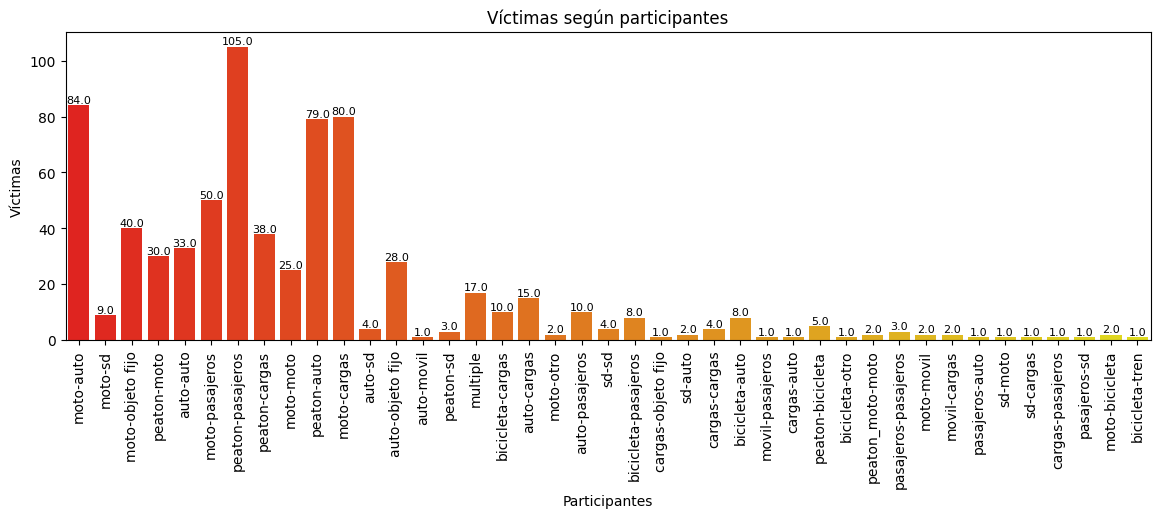

In [ ]:
plt.figure(figsize=(14, 4))

ax=sns.countplot(sin, x="participantes", palette="autumn")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=90)

plt.xlabel('Participantes')
plt.ylabel('Víctimas')
plt.title('Víctimas según participantes')

plt.show()

La relación es víctima-acusado.

El par más común es peatón-pasajero (transeunte y no-conductor), seguido del par moto-auto y moto-cargas.

# Matriz de confusión

In [ ]:
tabla_contingencia = pd.crosstab(sin['victima'], sin['acusado'])
tabla_contingencia

acusado,auto,bicicleta,cargas,moto,multiple,objeto fijo,otro,pasajeros,tren
victima,,,,,,,,,
auto,33,0,15,0,3,26,1,10,0
bicicleta,8,0,10,0,1,0,1,8,1
cargas,1,0,4,0,0,1,0,1,0
moto,84,2,80,25,8,40,4,50,0
movil,0,0,2,0,0,0,0,1,0
objeto fijo,2,0,0,0,0,0,0,0,0
pasajeros,1,0,0,0,0,0,0,3,0
peaton,79,5,38,30,5,0,0,105,0
peaton_moto,0,0,0,2,0,0,0,0,0


Cuando el acusado son pasajeros, las víctimas suelen ser peatones y motos.

En cambio cuando el acusado en de tipo cargas, las víctimas suelen ser motos y peatones.

Por último cuando el acusado es auto, la víctima suele ser moto, peatones y autos en ese orden.

# Acusados

/var/folders/vk/hsfysc513dd4j0c513j6pl3r0000gn/T/ipykernel_3915/3893793735.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(sin, x="acusado", palette="autumn")


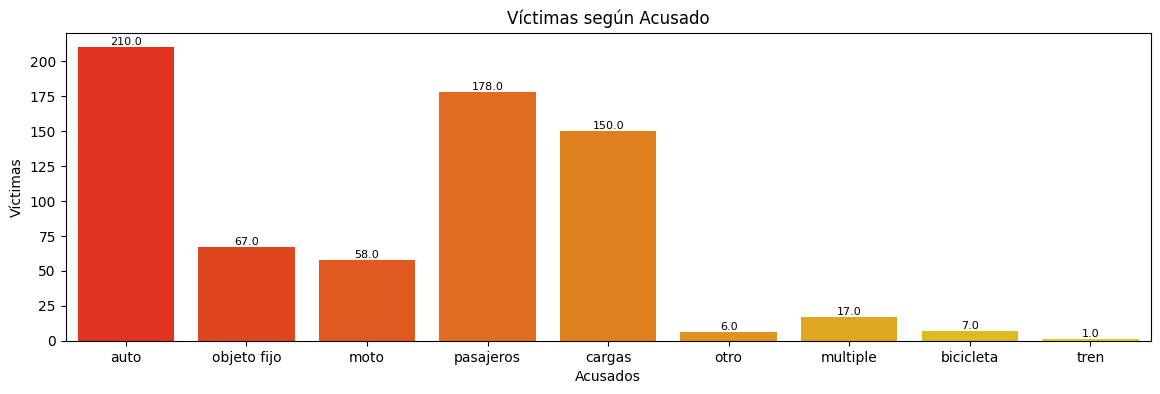

In [ ]:
plt.figure(figsize=(14, 4))

ax=sns.countplot(sin, x="acusado", palette="autumn")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)

plt.xlabel('Acusados')
plt.ylabel('Víctimas')
plt.title('Víctimas según Acusado')

plt.show()

La mayoría de acusados estaba en un auto, seguido de pasajeros y cargas.

# Comunas

In [ ]:
Total_comuna=sin.groupby(["comuna", "barrios"])["n_victimas"].sum().reset_index()
Total_comuna=Total_comuna.sort_values(by="n_victimas", ascending=False)
Total_comuna

,comuna,barrios,n_victimas
0,1,constitucion - montserrat - puerto madero - re...,101
3,4,barracas - boca - nueva pompeya - parque patri...,85
8,9,liniers - mataderos - parque avellaneda,79
7,8,villa lugano - villa riachuelo - villa soldati,71
6,7,flores - parque chacabuco,66
2,3,balvanera - san cristobal,48
14,15,agronomia - chacarita - parque chas - patern...,47
11,12,coghlan - saavedra - villa pueyrredon - villa ...,43
13,14,palermo,41
12,13,belgrano - colegiales - nuñez,40


Los siniestros se concentran en las comunas 1, 4, 9 y 8. Es decir, en el centro y en las comunas aledañas al río riachuelo.

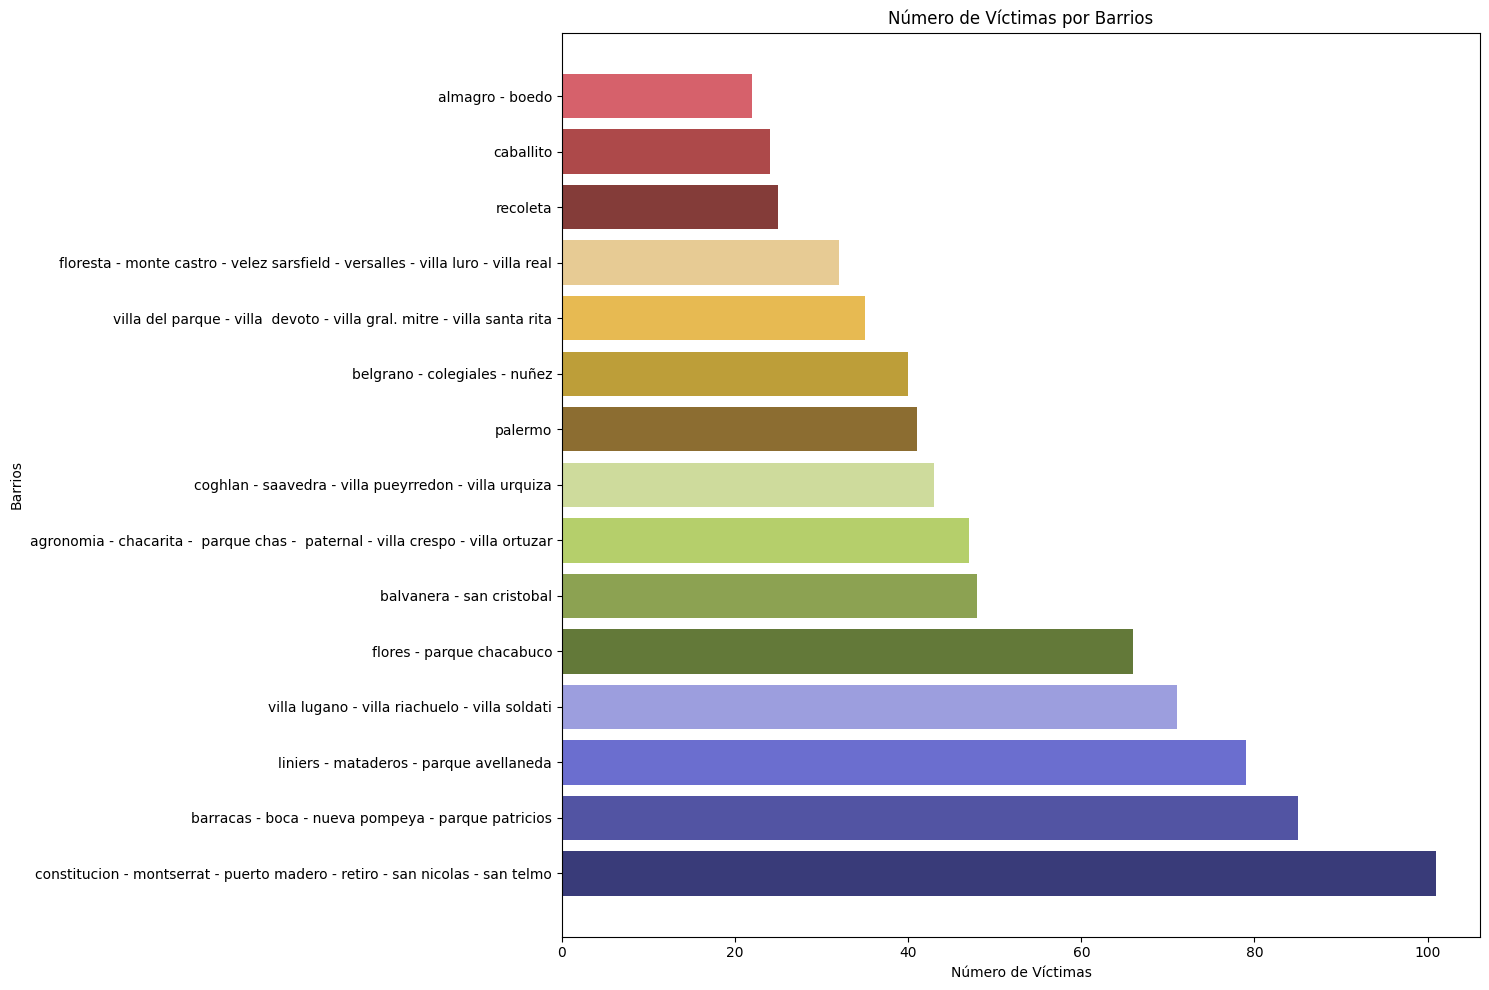

In [ ]:
plt.figure(figsize=(15, 10))

colores = plt.cm.tab20b(range(len(Total_comuna)))

plt.barh(Total_comuna["barrios"], Total_comuna["n_victimas"], color=colores)

plt.xlabel('Número de Víctimas')
plt.ylabel('Barrios')

plt.title('Número de Víctimas por Barrios')

for i, v in enumerate(Total_comuna["n_victimas"]):
    plt.text(v, i, str(v), va='center', fontsize=8, color='white')

plt.tight_layout()
plt.show()

# Tipos de calle

/var/folders/vk/hsfysc513dd4j0c513j6pl3r0000gn/T/ipykernel_3915/3316149156.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(sin, x='tipo de calle', palette="spring")


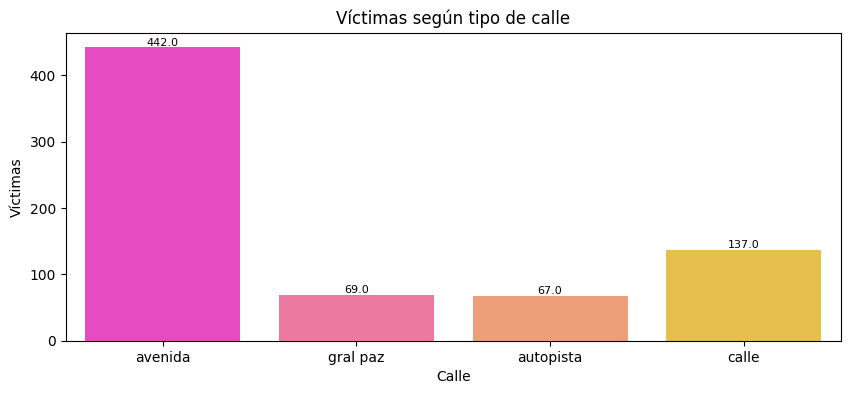

In [ ]:
plt.figure(figsize=(10, 4))

ax=sns.countplot(sin, x='tipo de calle', palette="spring")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)

plt.xlabel('Calle')
plt.ylabel('Víctimas')
plt.title('Víctimas según tipo de calle')

plt.show()

La gran mayoría de los siniestros, por una diferencia notoria, se dan en avenidas, seguido por calles. En la primera se puede decir que existe convivencia con el resto de los medios de transporte y mayor velocidad.

# Mapa

In [18]:
sino = sin[(sin["pos y"] != ".") & (sin["pos y"] != ".")]


In [12]:
# Iniciamos CRS

crs={'init':'epsg:4326'}

In [21]:
#Definimos la geometría según nuestro dataset
geometry=[Point(xy) for xy in zip(sino["pos x"], sino["pos y"])]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

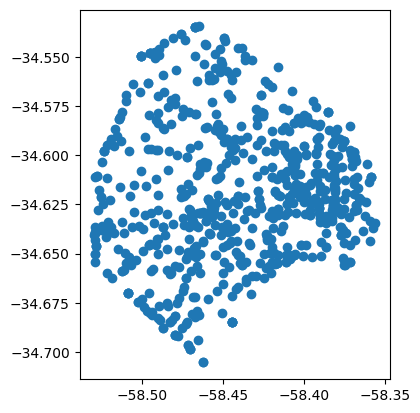

In [23]:
#Ua vez que tenemos el sistema de referencia decoordenadas y la geometría; se procede a la carga de los datos
geodata=gpd.GeoDataFrame(sino,crs=crs, geometry=geometry)

#Se imprime el resultante que luego será introducido en un mapa
geodata.plot()

# Resoluciones

1. Enfocarse en los tipos de víctimas más vulnerables:
   - Motociclistas: Implementar campañas de concienciación a jovenes motociclistas sobre la seguridad vial para este grupo, incluyendo el uso obligatorio de cascos y equipamiento adecuado.
   - Peatones: Mejorar la infraestructura vial para la seguridad de peatones pensando en el adulto mayor, como la construcción de aceras, pasos de peatones y ciclovías.
2. Reducir la velocidad en zonas de alto riesgo:
   - Implementar en vias de alto riesgo en las avenidas medidas de control de velocidad como reductores de velocidad, radares y mayor presencia policial.
3. Recopilación y análisis de datos:
   - Implementar un sistema de recopilación de datos más robusto y preciso sobre accidentes de tránsito, incluyendo información sobre las causas, las víctimas y las condiciones ambientales.
   - Utilizar el análisis de datos para identificar patrones y factores de riesgo en los accidentes de tránsito.
4. Campañas de concienciación vial:
   - Implementar campañas de concienciación vial dirigidas a toda la población, en especial a las comunas 1, 4, 9 y 8, incluyendo conductores, motociclistas, peatones y ciclistas.
   - Enfatizar la importancia de la responsabilidad individual en la seguridad vial.